In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.abspath(current_dir)))
from Grover.grover_num_list_cirq import find_num, find_num_list
from Backend.fake_backend import FakeBackend
from Backend.backend import Backend
from Backend.ibm_backend import IBM_backend

from Result.result import ResultData

from qiskit.visualization import plot_histogram, plot_coupling_map
from qiskit import transpile
import qiskit.providers.fake_provider
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.passes import RemoveBarriers

from itertools import permutations

from SaveData.save_data_to_file import CSVWriter
import time

In [2]:
draw_circuit = False

In [36]:
# Sample of Finding a number in a list Grover circuit
winner_list = [4]
num_array = [0, 5, 7, 8, 2, 4, 9, 10, 3, 2, 9, 0, 2, 3, 4, 5]
find_num_in_data = find_num_list()
find_num_in_data.build_iteration(winner_list=winner_list, num_array=num_array, block_diagram=False, default_value=0)
find_num_in_data.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_data.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
print(f"Circuit Depth is : {cur_experiments[0].depth()}")
cur_experiments[0].draw('mpl') if draw_circuit else None

Number of Grover circuits : 1
Circuit Depth is : 356


In [144]:
# Sample of Find Number Grover Circuit
find_num_in_world_obj =  find_num()
winner_list = [6]
num_array = []
find_num_in_world_obj.build_iteration(winner_num_list=[6], circuit_nqubits=10, block_diagram=False)
find_num_in_world_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_world_obj.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
print(f"Circuit Depth is : {cur_experiments[0].depth()}")
cur_experiments[0].draw('mpl') if draw_circuit else None

Number of Grover circuits : 1
Circuit Depth is : 302


In [ ]:
# Getting the Fake backend List
FakeBackend.get_ibm_fake_backend_name_list()

In [3]:
# Getting the Fake backend List with qubit limits
FakeBackend.get_ibm_fake_backend_names_with_limit(20, 30)

['fake_algiers',
 'fake_almaden',
 'fake_auckland',
 'fake_boeblingen',
 'fake_cairo',
 'fake_cambridge',
 'fake_geneva',
 'fake_hanoi',
 'fake_johannesburg',
 'fake_kolkata',
 'fake_montreal',
 'fake_mumbai',
 'fake_paris',
 'fake_peekskill',
 'fake_poughkeepsie',
 'fake_singapore',
 'fake_sydney',
 'fake_toronto']

In [14]:
# Get Fake Backend by name
FakeBackend.get_ibm_fake_backend('fake_auckland')

In [145]:
aer_backend = Backend()

In [146]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_aer_opt_0 = transpile(cur_experiments[0], aer_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_aer_opt_0.depth()}")
transpiled_circuit_aer_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 128052


In [147]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_aer_opt_3 = transpile(cur_experiments[0], aer_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_aer_opt_3.depth()}")
transpiled_circuit_aer_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 127852


0.3192979


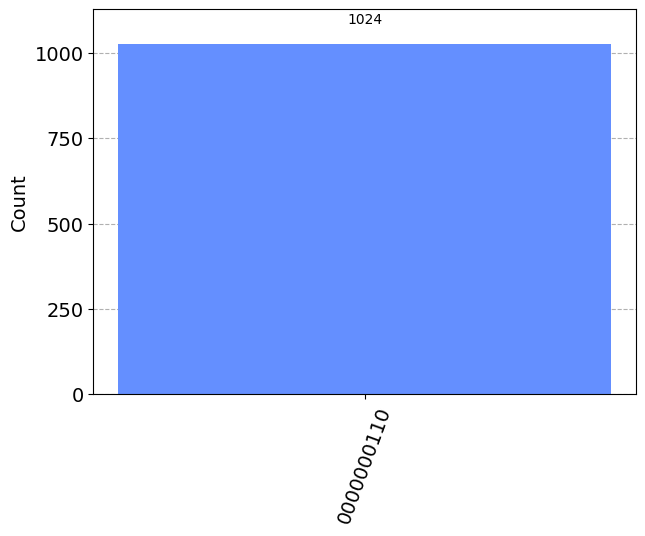

In [148]:
aer_job = aer_backend.run(transpiled_circuit_aer_opt_0)
aer_res = ResultData(aer_job)
print(aer_res.get_result_time_taken())
plot_histogram(aer_res.get_counts())

0.3277788


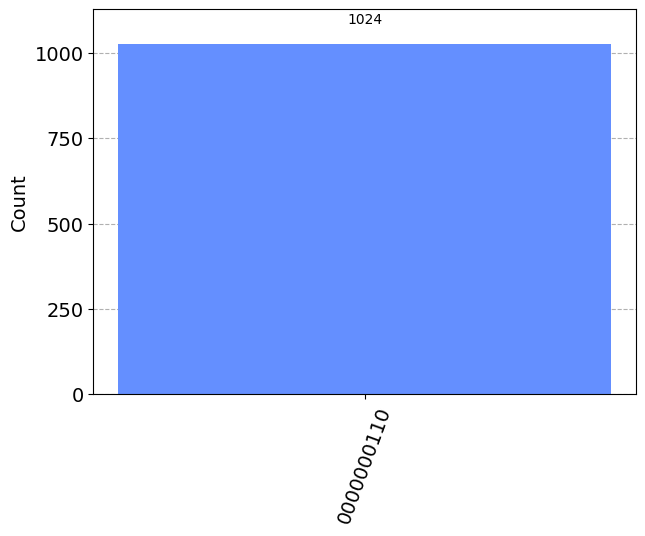

In [149]:
aer_job = aer_backend.run(transpiled_circuit_aer_opt_3)
aer_res = ResultData(aer_job)
print(aer_res.get_result_time_taken())
plot_histogram(aer_res.get_counts())

In [122]:
generic_backend = Backend(num_qubits=len(cur_experiments[0].qubits))

In [26]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_generic_opt_0 = transpile(cur_experiments[0], generic_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_generic_opt_0.depth()}")
transpiled_circuit_generic_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 62


In [27]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_generic_opt_3 = transpile(cur_experiments[0], generic_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_generic_opt_3.depth()}")
transpiled_circuit_generic_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 59


In [ ]:
generic_job = generic_backend.run(transpiled_circuit_generic_opt_0)
generic_res = ResultData(generic_job)
print(generic_res.get_result_time_taken())
plot_histogram(generic_res.get_counts())

In [ ]:
generic_job = generic_backend.run(transpiled_circuit_generic_opt_3)
generic_res = ResultData(generic_job)
print(generic_res.get_result_time_taken())
plot_histogram(generic_res.get_counts())

In [150]:
fake_backend_name = 'fake_auckland'
fake_backend = FakeBackend(fake_backend_name)

In [151]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_fake_opt_0 = transpile(cur_experiments[0], fake_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_fake_opt_0.depth()}")
transpiled_circuit_fake_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 235687


In [152]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_fake_opt_3 = transpile(cur_experiments[0], fake_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_fake_opt_3.depth()}")
transpiled_circuit_fake_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 199483


In [153]:
fake_job = fake_backend.run(transpiled_circuit_fake_opt_0, shots=4092)
fake_res = ResultData(fake_job)
print(fake_res.get_result_time_taken())
plot_histogram(fake_res.get_counts())

0.1357809


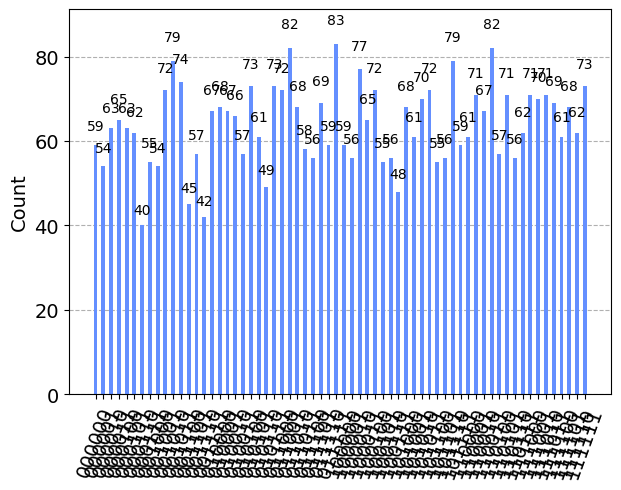

In [ ]:
fake_job = fake_backend.run(transpiled_circuit_fake_opt_3, shots = 4092)
fake_res = ResultData(fake_job)
print(fake_res.get_result_time_taken())
plot_histogram(fake_res.get_counts())

In [98]:
find_num_obj = find_num()
num_qubits = 6
experiments = []
seed = 42

aer_backend = Backend()
generic_backend = Backend(num_qubits=num_qubits)
fake_backend = FakeBackend('fake_auckland')
input_search_val = []
for value in range(2**num_qubits):
    if value != 6:
        continue
    input_search_val.append(value)
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    experiments.append(find_num_obj.measure_qc[0])

In [99]:
qc_without_barriar_list = [RemoveBarriers()(qc) for qc in experiments]

In [100]:
position_layout_addition = [] # list(permutations(range(num_qubits), num_qubits))

In [ ]:
length = 10
seed = 42
total_start_time = time.time()

# Running on all circuits without barriars
for input_val, cur_qc in zip(input_search_val, qc_without_barriar_list):
    input_dict = {'input_search' : input_val}
    # Running on all backends
    position_layout = [None] + list(permutations(range(cur_qc.num_qubits), cur_qc.num_qubits)) + position_layout_addition
    perm_index = 0
    # Running on all layouts
    # Note : Each length, will save the file to excell
    while perm_index < len(position_layout):
        qc_transpiled_list = []
        cur_perm_list = position_layout[perm_index : perm_index + length]
        print(f"Running from index {perm_index} to {perm_index + length} of position layout\n")
        for cur_backend in [aer_backend, generic_backend, fake_backend]:
            for index, layout in enumerate(cur_perm_list):
                # Running on all opt levels
                for opt_level in [0,3]:
                    start_time = time.time()
                    qc_transpiled_list.append(cur_backend.transpile_save_param(qc=cur_qc, optimization_level=opt_level, initial_layout=layout, seed_transpiler=None, 
                                                                            **input_dict))
                    print(f"Finished circuit with Opt {opt_level} for layout {layout} indexed {index} for current loop for backend {cur_backend.get_backend().name} in {round(time.time() - start_time, 3)} Seconds")
        # Running circuits with seeds
        run_start_time = time.time()
        qc_run_result = []
        data_save = []
        for index, qc in enumerate(qc_transpiled_list):
            for seed_val in [None, seed]:
                start_time = time.time()
                qc_result = qc.backend.run(qc.transpiled_qc, shots = 1024, seed_simulator = seed_val)
                qc_result = ResultData(qc_result)
                qc_result.set_seed(seed_val)
                data_save.append([qc, qc_result])
                print(f"Finished running circuit indexed {index} out of {len(qc_transpiled_list)} with seed {seed_val} in {round(time.time() - start_time,4)}  Seconds")
        print(f"Finished running all circuits in {round(time.time() - run_start_time,4)}  Seconds")
        # Saving file for each circuit
        start_time = time.time()
        additional_txt = ""
        for key, value in input_dict.items():
            additional_txt = additional_txt + f"_K{key}_V{value}"
        excel_name = f"grover_results{additional_txt}.csv"
        save = CSVWriter(file_name=excel_name)
        save.save_data(data_save)
        print(f"Finished saving to csv at {round(time.time() - start_time,4)} seconds\n")
        perm_index = perm_index + length
print(f"### Finished all circuits in all configurations in {time.time() - total_start_time} Seconds ###")

In [17]:
position_layout = list(permutations(range(fake_backend.get_backend_qubits()), num_qubits))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001E098B37C10>>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 801, in _clean_thread_parent_frames
    for identity in list(thread_to_parent.keys()):
                         ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
length = 1
perm_index = 0
position_layout = list(permutations(range(num_qubits), num_qubits)) + position_layout_addition
while perm_index < len(position_layout):
    cur_perm = position_layout[perm_index : perm_index + length + 1]
    print(f"{cur_perm}\n")
    
    perm_index = perm_index + length + 1
    

In [ ]:
length = 1
perm_index = 0
position_layout_addition = []
position_layout = list(permutations(range(num_qubits), num_qubits)) + position_layout_addition

while perm_index < len(position_layout):
    start = time.time()
    print(f"Running from index {perm_index} to {perm_index + length} of position layout\n")
    cur_perm = position_layout[perm_index : perm_index + length]
    print(f"Running {len(cur_perm)} Position layouts\n")
    # Add the Generic Aer Full Connectivity
    qc_transpiled_list = [
        generic_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=None, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    cur_time = time.time() - start
    print(f"Opt 0 Fully Connected finished at {int(cur_time)} seconds\n")
    qc_transpiled_list = qc_transpiled_list + [
        generic_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=None, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    cur_time = time.time() - start
    print(f"Opt 3 Fully Connected finished at {int(cur_time)} seconds\n")
    # Add the fake backend
    for layout in [None] + cur_perm:
        qc_transpiled_list = qc_transpiled_list + [
            fake_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=layout, seed_transpiler=None, input_search = index)
            for index, qc in enumerate(qc_find_num_list_without_barriar)
        ]
        cur_time = time.time() - start
        print(f"Opt 0 FakeAucland with layout {layout} finished at {int(cur_time)} seconds\n")
        qc_transpiled_list = qc_transpiled_list + [
            fake_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=layout, seed_transpiler=None, input_search = index)
            for index, qc in enumerate(qc_find_num_list_without_barriar)
        ]
        cur_time = time.time() - start
        print(f"Opt 3 FakeAucland with layout {layout} finished at {int(cur_time)} seconds\n")
    qc_res  = [
        qc_param.backend.run(qc_param.transpiled_qc,shots=4096)
        for qc_param in qc_transpiled_list
    ]
    cur_time = time.time() - start
    print(f"Results without seed finished at {int(cur_time)} seconds\n")
    qc_res_seed  = [
        qc_param.backend.run(qc_param.transpiled_qc,shots=4096, seed_simulator=seed)
        for qc_param in qc_transpiled_list
    ]
    cur_time = time.time() - start
    print(f"Results with seed {seed} finished at {int(cur_time)} seconds\n")
    
    qc_resultData = [ResultData(res) for res in qc_res]
    qc_resultData_seed = [ResultData(res) for res in qc_res_seed]
    [res.set_seed(seed) for res in qc_resultData_seed]
    print(f"Start saving to csv seed starting to csv\n")
    excel_name = f"grover_results_{perm_index}_to_{perm_index + length}_perm.csv"
    save = CSVWriter(file_name=excel_name)
    data = []
    for qc_transpile, res_data, res_data_seed in zip(qc_transpiled_list, qc_resultData, qc_resultData_seed):
        data.append([qc_transpile, res_data])  
        data.append([qc_transpile, res_data_seed])  
    save.save_data(data)
    cur_time = time.time() - start
    print(f"Finished saving to csv at {int(cur_time)} seconds\n")
    perm_index = perm_index + length

In [16]:
# Add the Generic Aer Full Connectivity
qc_transpiled_list = [
    generic_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
qc_transpiled_list = qc_transpiled_list + [
    generic_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
position_layout = list(position_layout)
# Add the fake backend
for layout in [None] + position_layout + position_layout_addition:
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]

In [ ]:
# Sample that we entered an input value to the result parameters to save
qc_transpiled_list[60].backend_name

'fake_auckland'

In [ ]:
qc_res  = [
    qc_param.backend.run(qc_param.transpiled_qc,shots=1024)
    for qc_param in qc_transpiled_list
]

In [ ]:
qc_res_seed  = [
    qc_param.backend.run(qc_param.transpiled_qc,shots=1024, seed_simulator=seed)
    for qc_param in qc_transpiled_list
]

In [ ]:
len(qc_res)

224

In [ ]:
qc_resultData = [ResultData(res) for res in qc_res]

In [ ]:
qc_resultData_seed = [ResultData(res) for res in qc_res_seed]
x = [res.set_seed(seed) for res in qc_resultData_seed]

In [ ]:
len(qc_resultData)

224

In [ ]:
# excel_path = "../logs"
excel_name = "grover_results.csv"

save = CSVWriter(file_name=excel_name)

data = []
for qc_transpile, res_data, res_data_seed in zip(qc_transpiled_list, qc_resultData, qc_resultData_seed):
    data.append([qc_transpile, res_data])  
    data.append([qc_transpile, res_data_seed])  

save.save_data(data)

Data saved to ..\logs\grover_results_2024_08_09_22_03_54.csv


In [18]:
# Create the list of backends
backend_list = [Backend()]

# Add fake backend
fakebackend_name_list = FakeBackend.get_ibm_fake_backend_names_with_limit(20, 30)
fakebakcend_list = [FakeBackend(fake_name) for fake_name in fakebackend_name_list]
backend_list = backend_list + fakebakcend_list

In [88]:
find_num_obj = find_num()
num_qubits = 6
experiments = {}
seed = 42

# Get circuits for each value
for value in range(2**num_qubits):
    if value != 6:
        continue
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    experiments[value] = {}
    experiments[value]['circuit'] = find_num_obj.measure_qc[0]
    experiments[value]['additional'] = {'input_search' : value, 'input_num_qubits' : num_qubits}
# Remove barriars
for value in experiments:
    experiments[value]['circuit'] = RemoveBarriers()(experiments[value]['circuit'])

In [96]:
p=backend_list[3].transpile_save_param(experiments[6]['circuit'], optimization_level=0, **experiments[6]['additional'])

In [ ]:
p.transpiled_qc.draw()

In [100]:
m=p.backend.run(p.transpiled_qc, shots=1024, seed_simulator=42)

In [102]:
m.result()

Result(backend_name='aer_simulator', backend_version='0.14.0.1', qobj_id='', job_id='5d759269-218a-47b8-a873-8e904d92c717', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x38': 19, '0x30': 17, '0x7': 13, '0x8': 11, '0x37': 19, '0x0': 9, '0x1a': 13, '0x3e': 13, '0x22': 22, '0xb': 23, '0x2b': 10, '0x2': 17, '0x35': 13, '0x3d': 11, '0xc': 19, '0x23': 22, '0x33': 19, '0x4': 11, '0x2d': 21, '0xa': 13, '0x21': 20, '0x3f': 15, '0x25': 15, '0x3b': 10, '0xe': 16, '0x11': 18, '0x12': 21, '0x3a': 13, '0xf': 14, '0x26': 13, '0x19': 14, '0x32': 16, '0x2e': 12, '0x5': 17, '0x1c': 18, '0x1f': 17, '0x14': 15, '0x3': 10, '0x2c': 25, '0x34': 22, '0x20': 15, '0x39': 23, '0x1b': 10, '0x9': 12, '0x2a': 22, '0x1': 12, '0x36': 13, '0x27': 10, '0x15': 22, '0x1d': 16, '0x2f': 13, '0x6': 23, '0x31': 21, '0x1e': 17, '0x10': 11, '0x28': 15, '0x3c': 16, '0xd': 20, '0x24': 19, '0x13': 16, '0x17': 12, '0x16': 19, '0x18': 16, '0x29': 15}), header=Qo

In [70]:
for value, data in experiments.items():
    value_start_time = time.time()
    data_save = []
    start_time = time.time()
    print(f"Running circuit on searchable value {value}")
    for index, backend in enumerate(backend_list):
        print(f"Value {value} : Running on backend {backend.get_backend().name} (Backend index {index} in list)")
        data[f"{backend.get_backend().name}"] = {}
        for opt_level in [0,3]:
            opt_time = time.time()
            data[f"{backend.get_backend().name}"][f"Level_{opt_level}"] = backend.transpile_save_param(qc=data['circuit'], optimization_level=opt_level, initial_layout=None, seed_transpiler=None, **data['additional'])
            print(f"Finsihed transpiling backend with opt {opt_level} for {time.time() - opt_time} seconds")
    print(f"Value {value} : Finished transpiling for all backend : {time.time() - start_time} seconds")
    break
    experiments[6]['fake_auckland'][f'Level_0']
    y =x.backend.run(x.transpiled_qc, shots = 1024, seed_simulator = seed_val)
    z = ResultData(y)

Running circuit on searchable value 6
Value 6 : Running on backend aer_simulator (Backend index 0 in list)
Finsihed transpiling backend with opt 0 for 0.06613492965698242 seconds
Finsihed transpiling backend with opt 3 for 0.2665424346923828 seconds
Value 6 : Running on backend fake_algiers (Backend index 1 in list)
Finsihed transpiling backend with opt 0 for 0.4035484790802002 seconds
Finsihed transpiling backend with opt 3 for 2.9932923316955566 seconds
Value 6 : Running on backend fake_almaden (Backend index 2 in list)
Finsihed transpiling backend with opt 0 for 0.3501420021057129 seconds
Finsihed transpiling backend with opt 3 for 2.08771014213562 seconds
Value 6 : Running on backend fake_auckland (Backend index 3 in list)
Finsihed transpiling backend with opt 0 for 0.4107236862182617 seconds
Finsihed transpiling backend with opt 3 for 2.5387089252471924 seconds
Value 6 : Running on backend fake_boeblingen (Backend index 4 in list)
Finsihed transpiling backend with opt 0 for 0.3404

In [71]:
experiments[6]['fake_auckland']

{'Level_0': <Backend.backend.saved_transpile_action_parameters at 0x1d34fe93950>,
 'Level_3': <Backend.backend.saved_transpile_action_parameters at 0x1d3247c6050>}

In [77]:
x=experiments[6]['fake_auckland'][f'Level_0']

In [79]:
x.backend

In [80]:
y =x.backend.run(x.transpiled_qc, shots = 1024, seed_simulator = seed_val)

In [83]:
y.result().get_counts()


{'010111': 12,
 '001000': 6,
 '011010': 14,
 '111110': 13,
 '100010': 23,
 '001011': 20,
 '101011': 12,
 '000010': 18,
 '110101': 21,
 '010000': 11,
 '111101': 11,
 '001100': 17,
 '100011': 22,
 '111000': 17,
 '110011': 17,
 '000100': 14,
 '101101': 20,
 '001010': 12,
 '100001': 22,
 '111111': 15,
 '100101': 14,
 '111011': 12,
 '001110': 15,
 '010001': 16,
 '111010': 12,
 '001111': 14,
 '100110': 13,
 '011001': 14,
 '110010': 17,
 '101110': 12,
 '000101': 19,
 '011100': 17,
 '011111': 19,
 '010100': 12,
 '000011': 8,
 '101100': 25,
 '110100': 22,
 '100000': 16,
 '010010': 22,
 '111001': 25,
 '011011': 16,
 '001001': 13,
 '100111': 11,
 '000000': 8,
 '110111': 19,
 '000111': 11,
 '110000': 10,
 '101010': 20,
 '110110': 12,
 '000001': 13,
 '001101': 23,
 '111100': 17,
 '100100': 17,
 '011101': 16,
 '011110': 16,
 '101000': 16,
 '101001': 17,
 '101111': 13,
 '110001': 20,
 '000110': 24,
 '011000': 19,
 '010101': 20,
 '010110': 18,
 '010011': 14}

In [84]:
z = ResultData(y)

In [85]:
z.get_counts()

{'010111': 12,
 '001000': 6,
 '011010': 14,
 '111110': 13,
 '100010': 23,
 '001011': 20,
 '101011': 12,
 '000010': 18,
 '110101': 21,
 '010000': 11,
 '111101': 11,
 '001100': 17,
 '100011': 22,
 '111000': 17,
 '110011': 17,
 '000100': 14,
 '101101': 20,
 '001010': 12,
 '100001': 22,
 '111111': 15,
 '100101': 14,
 '111011': 12,
 '001110': 15,
 '010001': 16,
 '111010': 12,
 '001111': 14,
 '100110': 13,
 '011001': 14,
 '110010': 17,
 '101110': 12,
 '000101': 19,
 '011100': 17,
 '011111': 19,
 '010100': 12,
 '000011': 8,
 '101100': 25,
 '110100': 22,
 '100000': 16,
 '010010': 22,
 '111001': 25,
 '011011': 16,
 '001001': 13,
 '100111': 11,
 '000000': 8,
 '110111': 19,
 '000111': 11,
 '110000': 10,
 '101010': 20,
 '110110': 12,
 '000001': 13,
 '001101': 23,
 '111100': 17,
 '100100': 17,
 '011101': 16,
 '011110': 16,
 '101000': 16,
 '101001': 17,
 '101111': 13,
 '110001': 20,
 '000110': 24,
 '011000': 19,
 '010101': 20,
 '010110': 18,
 '010011': 14}

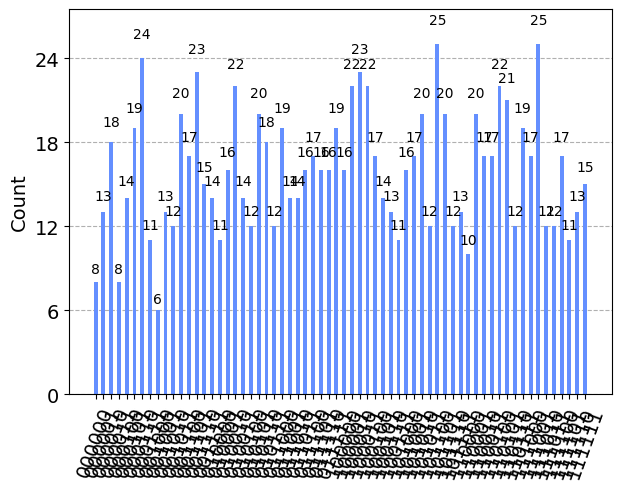

In [87]:
plot_histogram(z.get_counts())

In [63]:

all_values_time = time.time()
for value, data in experiments.items():
    value_start_time = time.time()
    qc_transpiled_list = []
    data_save = []
    start_time = time.time()
    print(f"Running circuit on searchable value {value}")
    for backend in backend_list:
        print(f"Value {value} : Running on backend {backend.get_backend().name}")
        for opt_level in [0,3]:
            opt_time = time.time()
            qc_transpiled_list.append(backend.transpile_save_param(qc=data['circuit'], optimization_level=opt_level, initial_layout=None, seed_transpiler=None, **data['additional']))
            print(f"Finsihed transpiling backend with opt {opt_level} for {time.time() - opt_time} seconds")
    print(f"Value {value} : Finished transpiling for all backend : {time.time() - start_time} seconds")
    
    start_time = time.time()
    for index, qc in enumerate(qc_transpiled_list):
        for seed_val in [seed]:
            start_time = time.time()
            qc_result = qc.backend.run(qc.transpiled_qc, shots = 1024, seed_simulator = seed_val)
            qc_result = ResultData(qc_result)
            qc_result.set_seed(seed_val)
            data_save.append([qc, qc_result])
            experiments[value]['count'] = qc_result.get_counts()
            experiments[value]['result_time'] = qc_result.get_result_time_taken()
            print(f"Finished running circuit indexed {index} out of {len(qc_transpiled_list)} with seed {seed_val} in {round(time.time() - start_time,4)}  Seconds")
    print(f"Value {value} : Finished Running for all backend : {time.time() - start_time} seconds")
    additional_txt = ''
    for key, value in data['additional'].items():
        additional_txt = additional_txt + f"_{key}_{value}"
    excel_name = f"grover_results{additional_txt}.csv"
    save = CSVWriter(file_name=excel_name)
    save.save_data(data_save)
    print(f"Finished for value {value} in {time.time() - value_start_time} seconds")
    break
print(f"Finished all circuits in {time.time() - all_values_time}")

Running circuit on searchable value 6
Value 6 : Running on backend aer_simulator
Finsihed transpiling backend with opt 0 for 0.06629562377929688 seconds
Finsihed transpiling backend with opt 3 for 0.7440011501312256 seconds
Value 6 : Running on backend fake_algiers
Finsihed transpiling backend with opt 0 for 0.3996758460998535 seconds
Finsihed transpiling backend with opt 3 for 2.6364009380340576 seconds
Value 6 : Running on backend fake_almaden
Finsihed transpiling backend with opt 0 for 0.3469414710998535 seconds
Finsihed transpiling backend with opt 3 for 2.096721887588501 seconds
Value 6 : Running on backend fake_auckland
Finsihed transpiling backend with opt 0 for 0.40129542350769043 seconds
Finsihed transpiling backend with opt 3 for 2.585721969604492 seconds
Value 6 : Running on backend fake_boeblingen
Finsihed transpiling backend with opt 0 for 0.34220242500305176 seconds
Finsihed transpiling backend with opt 3 for 2.142322540283203 seconds
Value 6 : Running on backend fake_cai

In [64]:
experiments

{6: {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1d3544eced0>,
  'additional': {'input_search': 6, 'input_num_qubits': 6},
  'count': {'011100': 12,
   '001111': 9,
   '111010': 19,
   '100110': 10,
   '011001': 20,
   '110110': 11,
   '101010': 15,
   '000001': 17,
   '001010': 15,
   '111111': 12,
   '100001': 24,
   '010000': 18,
   '010101': 24,
   '101100': 15,
   '000011': 10,
   '110100': 27,
   '111001': 18,
   '111100': 18,
   '001101': 16,
   '100100': 16,
   '010010': 17,
   '101101': 12,
   '110011': 20,
   '000100': 21,
   '000111': 14,
   '110000': 17,
   '111101': 14,
   '001100': 24,
   '100011': 9,
   '111000': 26,
   '011000': 21,
   '111110': 16,
   '100010': 9,
   '001011': 22,
   '101111': 10,
   '110001': 17,
   '000110': 16,
   '001000': 17,
   '010001': 25,
   '000010': 8,
   '101011': 14,
   '110101': 14,
   '011101': 17,
   '110111': 6,
   '000000': 11,
   '001001': 26,
   '010100': 12,
   '110010': 11,
   '101110': 13,
   '000101': 27,
   '0